In [9]:
# ! ln ../bcc/inputs/163_A1*.npy inputs
# ! ln ../bcc/gnn_models/4.model.pth models/tumor_map_gnn.pth
# ! ln ../bcc/pretrain_model.pth models/tumor_map_cnn.pth
# ! ln ../fat_dermis_epi_sq_model/v2/checkpoints_tissue_seg/104.checkpoint.pth models/macro_map_cnn.pth
# ! ln ../nuclei_pipeline/seg_model/27.checkpoint.pth models/nuclei.pth
# ! cp -al ../bcc/web_test/openseadragon dzi_files
# torch.save(GCNNet(2048, 4, [32]*3).state_dict(),"models/macro_map_gnn.pth")
# ! pip uninstall pathpretrain -y && pip install git+https://github.com/jlevy44/PathPretrain
! cd ../ArcticAI_Prototype/ && git add * */* && git commit -a -m "workflow update" && git push

[master 948b668] workflow update
 Committer: Joshua J. Levy <f003k8w@p02.hpcc.dartmouth.edu>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 23 insertions(+), 61 deletions(-)
Counting objects: 4, done.
Delta compression using up to 80 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 983 bytes | 122.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/jlevy44/ArcticAI_Prototype
   18e731a..948b668  master -> master


In [ ]:
# preprocess

In [24]:
import os, tqdm
import numpy as np, pandas as pd
from pathflowai.utils import generate_tissue_mask
from itertools import product
from scipy.ndimage.morphology import binary_fill_holes as fill_holes

def preprocess(basename="163_A1a",
               threshold=0.05,
               patch_size=256):
    
    image=f"inputs/{basename}.npy"
    basename=os.path.basename(image).replace('.npy','')
    image=np.load(image)
    
    masks=dict()
    masks['tumor_map']=generate_tissue_mask(image,
                             compression=10,
                             otsu=False,
                             threshold=240,
                             connectivity=8,
                             kernel=5,
                             min_object_size=100000,
                             return_convex_hull=False,
                             keep_holes=False,
                             max_hole_size=6000,
                             gray_before_close=True,
                             blur_size=51) 
    x_max,y_max=masks['tumor_map'].shape
    masks['macro_map']=fill_holes(masks['tumor_map'])
    
    patch_info=dict()
    for k in masks:
        patch_info[k]=pd.DataFrame([[basename,x,y,patch_size,"0"] for x,y in tqdm.tqdm(list(product(range(0,x_max-patch_size,patch_size),range(0,y_max-patch_size,patch_size))))],columns=['ID','x','y','patch_size','annotation'])
        patches=np.stack([image[x:x+patch_size,y:y+patch_size] for x,y in tqdm.tqdm(patch_info[k][['x','y']].values.tolist())])                   
        include_patches=np.stack([masks[k][x:x+patch_size,y:y+patch_size] for x,y in tqdm.tqdm(patch_info[k][['x','y']].values.tolist())]).mean((1,2))>=threshold

        np.save(f"masks/{basename}_{k}.npy",masks[k])
        np.save(f"patches/{basename}_{k}.npy",patches[include_patches]) 
        patch_info[k].iloc[include_patches].to_pickle(f"patches/{basename}_{k}.pkl")



In [2]:
# preprocess(basename="163_A1a",
#                threshold=0.05,
#                patch_size=256)

In [3]:
# test component

In [25]:
# predict model
import os, torch, tqdm, pandas as pd, numpy as np
from torch.utils.data import Dataset, DataLoader 
from PIL import Image
from pathpretrain.train_model import train_model, generate_transformers, generate_kornia_transforms

class CustomDataset(Dataset):
    # load using saved patches and mask file
    def __init__(self, patch_info, npy_file, transform):
        self.X=np.load(npy_file)
        self.patch_info=pd.read_pickle(patch_info)
        self.xy=self.patch_info[['x','y']].values
        self.patch_size=self.patch_info['patch_size'].iloc[0]
        self.length=self.patch_info.shape[0]
        self.transform=transform
        self.to_pil=lambda x: Image.fromarray(x)
        self.ID=os.path.basename(npy_file).replace(".npy","")
        
    def __getitem__(self,i):
        x,y=self.xy[i]
        return self.transform(self.to_pil(self.X[i]))#[x:x+patch_size,y:y+patch_size]
        
    def __len__(self):
        return self.length
    
    def embed(self,model,batch_size,out_dir):
        Z=[]
        dataloader=DataLoader(self,batch_size=batch_size,shuffle=False)
        n_batches=len(self)//batch_size
        with torch.no_grad():
            for i,X in tqdm.tqdm(enumerate(dataloader),total=n_batches):
                if torch.cuda.is_available(): X=X.cuda()
                z=model(X).detach().cpu().numpy()
                Z.append(z)
        Z=np.vstack(Z)
        torch.save(dict(embeddings=Z,patch_info=self.patch_info),os.path.join(out_dir,f"{self.ID}.pkl"))
        
def generate_embeddings(basename="163_A1a",
                        analysis_type="tumor",
                       gpu_id=0):
    patch_info_file,npy_file=f"patches/{basename}_{analysis_type}_map.pkl",f"patches/{basename}_{analysis_type}_map.npy"
    models={k:f"models/{k}_map_cnn.pth" for k in ['macro','tumor']}
    num_classes=dict(macro=4,tumor=2)
    train_model(model_save_loc=models[analysis_type],extract_embeddings=True,num_classes=num_classes[analysis_type],predict=True,embedding_out_dir="cnn_embeddings/",custom_dataset=CustomDataset(patch_info_file,npy_file,generate_transformers(224,256)['test']),gpu_id=gpu_id)



In [5]:
# generate_embeddings(basename="163_A1a",
#                         analysis_type="tumor",
#                        gpu_id=0)
# generate_embeddings(basename="163_A1a",
#                         analysis_type="macro",
#                        gpu_id=0)

In [6]:
# create graph

In [7]:
import os, torch, numpy as np, pandas as pd
import pickle
import scipy.sparse as sps
from torch_geometric.utils import subgraph, add_remaining_self_loops
from torch_cluster import radius_graph
from collections import Counter
from torch_geometric.data import Data 

def create_graph_data(basename="163_A1a",
                      analysis_type="tumor",
                      radius=256,
                      min_component_size=600):
    embeddings=torch.load(f"cnn_embeddings/{basename}_{analysis_type}_map.pkl")
    xy=torch.tensor(embeddings['patch_info'][['x','y']].values).float().cuda()
    X=torch.tensor(embeddings['embeddings'])
    G=radius_graph(xy, r=radius*np.sqrt(2), batch=None, loop=True)
    G=G.detach().cpu()
    G=add_remaining_self_loops(G)[0]
    xy=xy.detach().cpu()
    datasets=[]
    edges=G.detach().cpu().numpy().astype(int)
    n_components,components=list(sps.csgraph.connected_components(sps.coo_matrix((np.ones_like(edges[0]),(edges[0],edges[1])))))
    comp_count=Counter(components)
    components=torch.LongTensor(components)
    for i in range(n_components):
        if comp_count[i]>=min_component_size:
            G_new=subgraph(components==i,G,relabel_nodes=True)[0]
            xy_new=xy[components==i]
            X_new=X[components==i]
            np.random.seed(42)
            idx=np.arange(X_new.shape[0])
            idx2=np.arange(X_new.shape[0])
            np.random.shuffle(idx)
            train_idx,val_idx,test_idx=torch.tensor(np.isin(idx2,idx[:int(0.8*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.8*len(idx)):int(0.9*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.9*len(idx)):]))
            dataset=Data(x=X_new, edge_index=G_new, y_new=torch.ones(len(X_new)), edge_attr=None, pos=xy_new)
            dataset.train_mask=train_idx
            dataset.val_mask=val_idx
            dataset.test_mask=test_idx
            dataset.id=basename
            dataset.component=i
            datasets.append(dataset)
    pickle.dump(datasets,open(os.path.join('graph_datasets',f"{basename}_{analysis_type}_map.pkl"),'wb'))

In [8]:
# create_graph_data(basename="163_A1a",
#                       analysis_type="tumor",
#                       radius=256,
#                       min_component_size=600)
# create_graph_data(basename="163_A1a",
#                       analysis_type="macro",
#                       radius=256,
#                       min_component_size=600)

In [9]:
# predict graph

In [29]:
import os, torch, pickle, numpy as np, pandas as pd, torch.nn as nn
from torch_geometric.data import DataLoader as TG_DataLoader
from torch_geometric.utils import to_dense_batch, to_dense_adj, dense_to_sparse, dropout_adj, to_networkx
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class GCNNet(torch.nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128,128], p=0.5, p2=0.1, drop_each=True):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0])]+[GATConv(hidden_topology[i],hidden_topology[i+1]) for i in range(len(hidden_topology[:-1]))])
        self.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden_topology[-1], out_dim)
        self.drop_each=drop_each

    def forward(self, x, edge_index, edge_attr=None):
        for conv in self.convs:
            if self.drop_each and self.training: edge_index=self.drop_edge(edge_index)
            x = F.relu(conv(x, edge_index, edge_attr))
        if self.training:
            x = self.dropout(x)
        x = self.fc(x)
        return x
    
class GCNFeatures(torch.nn.Module):
    def __init__(self, gcn, bayes=False, p=0.05, p2=0.1):
        super(GCNFeatures, self).__init__()
        self.gcn=gcn
        self.drop_each=bayes
        self.gcn.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.gcn.dropout = nn.Dropout(p)
    
    def forward(self, x, edge_index, edge_attr=None):
        for i,conv in enumerate(self.gcn.convs):
            if self.drop_each: edge_index=self.gcn.drop_edge(edge_index)
            x = conv(x, edge_index, edge_attr)
            if i+1<len(self.gcn.convs):
                x=F.relu(x)
        if self.drop_each:
            x = self.gcn.dropout(x)
        y = self.gcn.fc(F.relu(x))#F.softmax()
        return x,y
    
def predict(basename="163_A1a",
            analysis_type="tumor",
            gpu_id=0):
    hidden_topology=dict(tumor=[32]*3,macro=[32]*3)
    num_classes=dict(macro=4,tumor=2)
    torch.cuda.set_device(gpu_id)
    dataset=pickle.load(open(os.path.join('graph_datasets',f"{basename}_{analysis_type}_map.pkl"),'rb'))
    model=GCNNet(dataset[0].x.shape[1],num_classes[analysis_type],hidden_topology=hidden_topology[analysis_type],p=0.,p2=0.)
    model=model.cuda()
    model.load_state_dict(torch.load(os.path.join("models",f"{analysis_type}_map_gnn.pth"),map_location=f"cuda:{gpu_id}" if gpu_id>=0 else "cpu"))
    dataloader=TG_DataLoader(dataset,shuffle=False,batch_size=1)
    model.eval()
    feature_extractor=GCNFeatures(model,bayes=False).cuda()
    graphs=[]
    for i,data in enumerate(dataloader):
        with torch.no_grad():
            graph = to_networkx(data).to_undirected()
            model.train(False)
            x=data.x.cuda()
            xy=data.pos.numpy()
            edge_index=data.edge_index.cuda()
            preds=feature_extractor(x,edge_index)
            z,y_pred=preds[0].detach().cpu().numpy(),preds[1].detach().cpu().numpy()
            graphs.append(dict(G=graph,xy=xy,z=z,y_pred=y_pred,slide=data.id,component=data.component))
    torch.save(graphs,os.path.join("gnn_results",f"{basename}_{analysis_type}_map.pkl"))


In [30]:
# predict(basename="163_A1a",
#             analysis_type="tumor",
#             gpu_id=0)
# predict(basename="163_A1a",
#             analysis_type="macro",
#             gpu_id=0)

In [31]:
# nuclei prediction

In [40]:
from PIL import Image
from torch.utils.data import Dataset
import torch, pandas as pd, numpy as np
import pickle
from pathpretrain.train_model import train_model, generate_transformers, generate_kornia_transforms
from tqdm import trange

class WSI_Dataset(Dataset):
    def __init__(self, patches, transform):
        self.patches=patches
        self.to_pil=lambda x: Image.fromarray(x)
        self.length=len(self.patches)
        self.transform=transform
        
    def __getitem__(self,idx):
        X=self.transform(self.to_pil(self.patches[idx]))
        return X,torch.zeros(X.shape[-2:]).unsqueeze(0).long()
    
    def __len__(self):
        return self.length
    
def predict_nuclei(basename="163_A1a",
                   gpu_id=0):
    analysis_type="tumor"
    patch_size=256
    patch_info_file,npy_file=f"patches/{basename}_{analysis_type}_map.pkl",f"patches/{basename}_{analysis_type}_map.npy"
    patches=np.load(npy_file)
    custom_dataset=WSI_Dataset(patches,generate_transformers(256,256)['test'])
    Y_seg=train_model(inputs_dir='inputs',
                    architecture='resnet50',
                    batch_size=512,
                    num_classes=2,
                    predict=True,
                    model_save_loc="models/nuclei.pth",
                    predictions_save_path='tmp_test.pkl',
                    predict_set='custom',
                    verbose=False,
                    class_balance=False,
                    gpu_id=gpu_id,
                    tensor_dataset=False,
                    semantic_segmentation=True,
                    custom_dataset=custom_dataset,
                    save_predictions=False)['pred']

    xy=pd.read_pickle(patch_info_file)[['x','y']].values
    img_shape=np.load(f"inputs/{basename}.npy",mmap_mode="r").shape[:-1]
    pred_mask=np.zeros(img_shape)
    for i in trange(Y_seg.shape[0]):
        x,y=xy[i]
        pred_mask[x:x+patch_size,y:y+patch_size]=Y_seg[i].argmax(0)
    pred_mask=pred_mask.astype(bool)
    np.save(f"nuclei_results/{basename}.npy",pred_mask)


In [33]:
# predict_nuclei(basename="163_A1a",
#                    gpu_id=0)

In [34]:
# estimate Mapper graphs macro+tumor

In [35]:
from torch_cluster import nearest
import sys, os, torch, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
sys.path.insert(0,os.path.abspath("./dgm/"))
from dgm.dgm import DGM
from umap import UMAP
import pickle

classes_=['dermis', 'epidermis', 'hole', 'subcutaneous tissue']

def relabel_tumor(graph_tumor,graph_macro):
    le=LabelEncoder().fit(classes_)
    re_idx=nearest(torch.tensor(graph_tumor['xy']), torch.tensor(graph_macro['xy'])).numpy()
    unassigned=(graph_tumor['xy']-graph_macro['xy'][re_idx]).sum()!=0
    macro_pred=graph_macro['y_pred'].argmax(1)
    tumor_pred=graph_tumor['y_pred'].argmax(1)
    benign=tumor_pred==0
    tumor_pred=tumor_pred.astype('str')
    tumor_pred[benign]=le.inverse_transform(macro_pred[re_idx][benign])
    tumor_pred[~benign]='tumor'
    tumor_pred[unassigned]='unassigned'
    graph_tumor['annotation']=tumor_pred
    return graph_tumor

def construct_mapper(graph):
    z=UMAP(n_components=2,random_state=42).fit_transform(graph['z'])
    return dict(out_res=DGM(num_intervals=2,overlap=0.01,min_component_size=100,eps=0.1, sdgm=True).fit_transform(graph['G'], z),graph=graph)

def get_interaction(out_graph,y_orig,res,lb=None,plot=False,le=None):
    if not isinstance(lb,type(None)):
        y_orig=lb.transform(y_orig)
    node_makeup={}# only if predict
    for node in out_graph.nodes():
        nodes=res['mnode_to_nodes'][node]
        node_makeup[node]=y_orig[np.array(list(nodes))].mean(0)
    edges = out_graph.edges()
    edge_weight=res['edge_weight']
    weights = np.array([edge_weight[(min(u, v), max(u, v))] for u, v in edges], dtype=np.float32)
    edgelist=list(edges)
    A=np.zeros((len(lb.classes_),len(lb.classes_)))
    for i in range(len(edgelist)):
        send=node_makeup[edgelist[i][0]]
        receive=node_makeup[edgelist[i][1]]
        a=np.outer(send,receive)
        a=(a+a.T)/2.*weights[i]
        A+=a
    invasion_mat=pd.DataFrame(A,columns=le.inverse_transform(np.arange(len(lb.classes_))),index=le.inverse_transform(np.arange(len(lb.classes_))))
    return invasion_mat

def calc_hole_vals(dgm_result,weights={'dermis':1,'epidermis':1,'subcutaneous tissue':1}):
    y_pred=dgm_result['graph']['y_pred'].argmax(1)
    out_graph,res=dgm_result['out_res']
    le=LabelEncoder().fit(classes_)
    area_hole=(le.inverse_transform(y_pred)=='hole').mean()
    hole_share=get_interaction(out_graph,y_pred,res,lb=LabelBinarizer().fit(np.arange(len(le.classes_))),le=le)['hole']
    hole_share=hole_share.loc[hole_share.index!='hole']
    hole_share=pd.DataFrame(hole_share).reset_index()
    hole_share2=hole_share.set_index('index')
    hole_share2['weight']=pd.Series(weights)
    hole_share2['importance']=hole_share2['weight']*hole_share2['hole']
    return hole_share2

def calc_tumor_vals(dgm_result,weights={'dermis':1,'epidermis':1,'subcutaneous tissue':1,'hole':1}):
    out_graph,res=dgm_result['out_res']
    le=LabelEncoder().fit(dgm_result['graph']['annotation'])
    y=le.transform(dgm_result['graph']['annotation'])
    tumor_share=get_interaction(out_graph,y,res,lb=LabelBinarizer().fit(np.arange(len(le.classes_))),le=le)['tumor']
    tumor_share=tumor_share.loc[~tumor_share.index.isin(['tumor','unassigned'])]
    tumor_share=pd.DataFrame(tumor_share).reset_index()
    tumor_share2=tumor_share.set_index('index')
    tumor_share2['weight']=pd.Series(weights)
    tumor_share2['importance']=tumor_share2['weight']*tumor_share2['tumor']
    return tumor_share2

def generate_quality_scores(basename):
    graphs={k:torch.load(os.path.join("gnn_results",f"{basename}_{k}_map.pkl")) for k in ['tumor','macro']}
    graphs['tumor']=[relabel_tumor(graph_tumor,graph_macro) for graph_tumor,graph_macro in zip(graphs['tumor'],graphs['macro'])]

    mapper_graphs=dict()
    for k in ['tumor','macro']:
        mapper_graphs[k]=[construct_mapper(graph) for graph in graphs[k]]

    scoring_fn=dict(tumor=calc_tumor_vals,macro=calc_hole_vals)
    quality_score=dict()

    for k in mapper_graphs:
        quality_score[k]=pd.concat([scoring_fn[k](dgm_result)['importance'] for dgm_result in mapper_graphs[k]],axis=1)
        quality_score[k].columns=[f'section_{i}' for i in range(1,len(quality_score[k].columns)+1)]

    pickle.dump(quality_score,open(f'quality_scores/{basename}.pkl','wb'))

In [36]:
# ink prediction

In [37]:
from skimage import morphology as morph
from scipy.ndimage import binary_opening, binary_dilation, label as scilabel
from skimage import filters, measure
from skimage.morphology import disk
import numpy as np, pandas as pd, copy
import sys,os,cv2
from itertools import product
sys.path.insert(0,os.path.abspath('.'))
from filters import filter_red_pen, filter_blue_pen, filter_green_pen

def filter_yellow(img): # https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
    img_hsv=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return cv2.inRange(img_hsv,(10, 30, 30), (30, 255, 255))

ink_fn=dict(red=filter_red_pen,
           blue=filter_blue_pen,
           green=filter_green_pen,
           yellow=filter_yellow)

ink_min_size=dict(red=100,
           blue=30,
           green=30,
           yellow=1000)

colors=dict(red=np.array([255,0,0]),
           blue=np.array([0,0,255]),
           green=np.array([0,255,0]),
           yellow=np.array([255,255,0]))

def tune_mask(mask,edges,min_size=30):
    mask=(binary_dilation(mask,disk(3,bool),iterations=5) & edges)
    mask=binary_opening(mask,disk(3,bool),iterations=1)
    return morph.remove_small_objects(mask, min_size=min_size, connectivity = 2, in_place=True)>0

def filter_tune(img,color,edges):
    return tune_mask(~ink_fn[color](img),edges,min_size=ink_min_size[color])

def get_edges(mask):
    edges=filters.sobel(mask)>0
    edges = binary_dilation(edges,disk(30,bool))
    return edges

def detect_inks(basename="163_A1a",
                compression=8):
    img,mask=np.load(f"inputs/{basename}.npy"),np.load(f"masks/{basename}_macro_map.npy")
    img=cv2.resize(img,None,fx=1/compression,fy=1/compression)
    mask=cv2.resize(mask.astype(int),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST).astype(bool)
    labels,n_objects=scilabel(mask)
    edges=get_edges(mask)
    pen_masks={k:filter_tune(img,k,edges) for k in ink_fn}

    for k in ['green','blue','red','yellow']:
        img[pen_masks[k],:]=colors[k]

    coords_df=pd.DataFrame(index=list(ink_fn.keys())+["center_mass"],columns=np.arange(1,n_objects+1))
    for color,obj in product(coords_df.index[:-1],coords_df.columns):
        coords_df.loc[color,obj]=np.vstack(np.where((labels==obj) & (pen_masks[color]))).T*compression
    for obj in coords_df.columns:
        coords_df.loc["center_mass",obj]=np.vstack(np.where(labels==obj)).T.mean(0)*compression

    coords_df.to_pickle(f"detected_inks/{basename}.pkl")
    np.save(f"detected_inks/{basename}_thumbnail.npy",img)

In [58]:
def run_workflow_series(basename):
    print(f"{basename} preprocessing")
    preprocess(basename=basename,
               threshold=0.05,
               patch_size=256)
    
    for k in ['tumor','macro']:
        print(f"{basename} {k} embedding")
        generate_embeddings(basename=basename,
                            analysis_type=k,
                           gpu_id=0)

        print(f"{basename} {k} build graph")
        create_graph_data(basename=basename,
                          analysis_type=k,
                          radius=256,
                          min_component_size=600)
        
        print(f"{basename} {k} gnn predict")
        predict(basename=basename,
                analysis_type=k,
                gpu_id=0)

    print(f"{basename} quality assessment")
    generate_quality_scores(basename)
    
    print(f"{basename} ink detection")
    detect_inks(basename=basename,
                compression=8)
    
    print(f"{basename} nuclei detection")
    predict_nuclei(basename=basename,
                   gpu_id=0)
    

In [61]:
import glob, os
def run_series(patient="163_A1"):
    for f in glob.glob(f"inputs/{patient}*.npy"):
        run_workflow_series(os.path.basename(f).replace(".npy",""))

In [ ]:
# blend predicted scores
# do later

In [ ]:
# organize / cut sections

In [4]:
import glob,pickle, numpy as np

def dump_results(patient="163_A1",scheme="2/1"):
    n_sections_per_slide,n_blocks_per_section=np.array(scheme.split("/")).astype(int)
    images=sorted(glob.glob(f"inputs/{patient}*.npy"))
    masks=sorted(glob.glob(f"masks/{patient}*macro*.npy"))
    tumor_gnn_results=sorted(glob.glob(f"gnn_results/{patient}*tumor*.pkl"))
    macro_gnn_results=sorted(glob.glob(f"gnn_results/{patient}*macro*.pkl"))
    quality_scores=sorted(glob.glob(f"quality_scores/{patient}*.pkl"))
    ink_results=sorted(glob.glob(f"detected_inks/{patient}*.pkl"))
    nuclei_results=sorted(glob.glob(f"nuclei_results/{patient}*.npy"))

    pickle.dump(dict(n_slides=len(images),
                    n_sections_per_slide=n_sections_per_slide,
                    n_blocks_per_section=n_blocks_per_section,
                    images=images,
                    masks=masks,
                    tumor_gnn_results=tumor_gnn_results,
                    macro_gnn_results=macro_gnn_results,
                    quality_scores=quality_scores,
                    ink_results=ink_results,
                    nuclei_results=nuclei_results),open(f'results/{patient}.pkl','wb'))


In [17]:
# estimate alignment parameters
# do later

In [18]:
# apply slide level alignment parameters to each exported image + mask
# original, macro, tumor, nuclei
# do later

In [ ]:
# quality score from adjacent sections after extracting mapper scores

In [28]:
import pandas as pd, numpy as np
from scipy.ndimage import label as scilabel
from skimage.measure import regionprops_table
import cv2, os, subprocess
from deepzoom import *
from deepzoom import _get_or_create_path,_get_files_path
from PIL import Image
import tqdm
import dask
from dask.diagnostics import ProgressBar
Image.MAX_IMAGE_PIXELS = None

class Numpy2DZI(ImageCreator):
    def __init__(
        self,
        tile_size=254,
        tile_overlap=1,
        tile_format="jpg",
        image_quality=0.8,
        resize_filter=None,
        copy_metadata=False,
        compression=1.
    ):
        super().__init__(tile_size,tile_overlap,tile_format,image_quality,resize_filter,copy_metadata)
        self.compression=compression
        
    def create(self, source_arr, destination):
        # speed up image saving with dask https://stackoverflow.com/questions/54615625/how-to-save-dask-array-as-png-files-slice-by-slice https://github.com/dask/dask-image/issues/110
        self.image = PIL.Image.fromarray(source_arr if self.compression==1 else cv2.resize(source_arr,None,fx=1/self.compression,fy=1/self.compression,interpolation=cv2.INTER_CUBIC))
        width, height = self.image.size
        self.descriptor = DeepZoomImageDescriptor(
            width=width,
            height=height,
            tile_size=self.tile_size,
            tile_overlap=self.tile_overlap,
            tile_format=self.tile_format,
        )
        image_files = _get_or_create_path(_get_files_path(destination))
        for level in tqdm.trange(self.descriptor.num_levels, desc='level'):
            level_dir = _get_or_create_path(os.path.join(image_files, str(level)))
            level_image = self.get_image(level)
            for (column, row) in tqdm.tqdm(self.tiles(level), desc='tiles'):
                bounds = self.descriptor.get_tile_bounds(level, column, row)
                tile = level_image.crop(bounds)
                format = self.descriptor.tile_format
                tile_path = os.path.join(level_dir, "%s_%s.%s" % (column, row, format))
                tile_file = open(tile_path, "wb")
                if self.descriptor.tile_format == "jpg":
                    jpeg_quality = int(self.image_quality * 100)
                    tile.save(tile_file, "JPEG", quality=jpeg_quality)
                else:
                    tile.save(tile_file)
        self.descriptor.save(destination)
        return destination
        
@dask.delayed
def write_dzi(img, out_dzi, compression=8):
    return Numpy2DZI(compression=compression).create(img,out_dzi)

def add_depth(x):
    x=x.sort_values(['slide_id',"section_id"])
    x['depth']=np.arange(1,len(x)+1)
    return x

def mask2label(mask,compression=8):
    mask_small=cv2.resize(mask.astype(int),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST).astype(bool)
    label=cv2.resize(scilabel(mask_small)[0],dsize=mask.shape[::-1],interpolation=cv2.INTER_NEAREST)
    return label

class Case:
    def __init__(self, patient="163_A1"):
        self.patient=patient
        self.results=pd.read_pickle(f"results/{patient}.pkl")
        self.slide_metadata,self.section_metadata=self.add_metadata(self.results)
        self.n_slides=self.results['n_slides']
        self.slide_cache=self.slide_metadata.copy()
        self.slide_cache['label']=''
        self.slide_cache['region_props']=''
        self.section_metadata['quality']=''
        self.max_depth=self.section_metadata['depth'].max()
        self.n_blocks=self.section_metadata['block_id'].max()
        
        
    def add_metadata(self, results):
        slide_metadata=pd.DataFrame({k:results[k] for k in results if isinstance(results[k],list)}).reset_index().rename(columns=dict(index="slide_id"))
        slide_metadata['slide_id']+=1
        section_metadata=dict(slide_id=[],
                             block_id=[],
                             section_id=[],
                             label_id=[])
        for slide in slide_metadata['slide_id'].values:
            section_metadata['label_id'].extend(np.arange(1,results['n_sections_per_slide']*results['n_blocks_per_section']+1))
            section_metadata['slide_id'].extend([slide]*(results['n_sections_per_slide']*results['n_blocks_per_section']))
            section_metadata['block_id'].extend(np.arange(1,results['n_blocks_per_section']+1).tolist()*results['n_sections_per_slide'])
            for i in range(1,results['n_sections_per_slide']+1): section_metadata['section_id'].extend([i]*results['n_blocks_per_section'])
        section_metadata=pd.DataFrame(section_metadata)
        section_metadata['id']=np.arange(len(section_metadata))
        section_metadata=pd.DataFrame(section_metadata.groupby("block_id").apply(add_depth)).reset_index(drop=True).sort_values(['id'])
        return slide_metadata,section_metadata
            
    
    def compute_quality(self):
        importance_regions={'dermis':3.,'epidermis':1.,'subcutaneous tissue':2.}
        importance_tumor=4.
        distance_weight=0.7
        baseline_region=1.

        quality_scores=self.slide_metadata['quality_scores'].map(pd.read_pickle)

        tumor_quality_scores=pd.concat([quality_scores[i]['tumor'] for i in range(self.n_slides)],axis=1).fillna(0).T.reset_index(drop=True)
        macro_quality_scores=pd.concat([quality_scores[i]['macro'] for i in range(self.n_slides)],axis=1).fillna(0).T.reset_index(drop=True)

        self.section_metadata['quality']=np.nan
        for block_id in self.section_metadata['block_id'].unique():
            idx=self.section_metadata['block_id'].values==block_id
            section_metadata_ids=self.section_metadata['id'].loc[idx]
            macro_qual,tumor_qual=macro_quality_scores.loc[idx],tumor_quality_scores.loc[idx]
            for i in range(len(macro_qual)):
                macro_qual['distance_weight']=distance_weight**(np.abs(macro_qual.index-i))
                tumor_qual['distance_weight']=distance_weight**(np.abs(tumor_qual.index-i))
                quality_score=pd.concat([importance_regions[region]*(macro_qual[region]*(baseline_region+tumor_qual[region]*tumor_qual["distance_weight"])) for region in importance_regions]+[importance_tumor*tumor_qual['hole']*tumor_qual["distance_weight"]],axis=1)
                quality_score.columns=list(importance_regions)+['hole']
                self.section_metadata.loc[self.section_metadata['id']==section_metadata_ids[i],'quality']=quality_score.values.sum()

    def load_slide(self, slide, compression=8):
        slide_loc=self.slide_metadata.index[np.where(self.slide_metadata['slide_id']==slide)[0][0]]
        if self.slide_cache.loc[slide_loc,['images','masks','label']].map(lambda x: isinstance(x,str)).sum()>0:
            self.slide_cache.loc[slide_loc,['images','masks']]=self.slide_metadata.loc[slide_loc,['images','masks']].map(np.load)
            self.slide_cache.loc[slide_loc,'label']=[mask2label(self.slide_cache.loc[slide_loc,'masks'],compression)]
            self.slide_cache.loc[slide_loc,'region_props']=[regionprops_table(self.slide_cache.loc[slide_loc,'label'], properties=['bbox'])] 
        image,mask,label=self.slide_cache.loc[slide_loc,['images','masks','label']].tolist()
        return image,mask,label

    def extract_section_image(self, depth, block_id, compression=8):
        section=self.section_metadata.loc[(self.section_metadata['depth']==depth) & (self.section_metadata['block_id']==block_id)]
        label_id,slide_id=section.loc[:,['label_id','slide_id']].values.flatten()
        image,mask,label=self.load_slide(slide_id,compression)
        
        bbox=pd.DataFrame(self.slide_cache.loc[self.slide_cache['slide_id']==slide_id,'region_props'].iloc[0])
        bbox.columns=['xmin','ymin','xmax','ymax']
        bbox.index+=1
        
        xmin,ymin,xmax,ymax=bbox.loc[label_id]
        img=image[xmin:xmax,ymin:ymax].copy()
        img[label[xmin:xmax,ymin:ymax]!=label_id]=255
        return img
    
    def write_dzi(self, img, out_dzi, compression=8):
        Numpy2DZI(compression=compression).create(img,out_dzi)
        
    def write_dzi_parallel(self, imgs, out_dzis, compression=8, scheduler='processes'):
        written_dzis=[]
        for img, out_dzi in zip(imgs,out_dzis):
            written_dzis.append(write_dzi(img, out_dzi, compression))
        with ProgressBar():
            written_dzis=dask.compute(*written_dzis, scheduler=scheduler)
        return written_dzis
    
    def launch_server(self, username='username', password='password', port=5554):
        subprocess.call(f"nohup sauth --dir dzi_files/ {username} {password} localhost {port} &",shell=True)
    
    def visualize_dzi(self, dzis):
        replace_txt='","'.join(list(map(os.path.basename,dzis)))
        with open("osd_template.html") as f_in, open('dzi_files/index.html','w') as f_out:
            f_out.write(f_in.read().replace("REPLACE",replace_txt).replace("BASENAME",self.patient))


In [29]:
case=Case()

In [3]:
imgs=[(case.patient,depth,block,case.extract_section_image(depth,block)) for block in tqdm.trange(1,case.n_blocks+1, desc='block') for depth in tqdm.trange(1,case.max_depth+1, desc='depth')]

depth: 100%|██████████| 6/6 [04:50<00:00, 48.41s/it]


In [19]:
ims=[im[-1] for im in imgs]
dzis=[f"dzi_files/{'_'.join(list(map(str,im[:3])))}.dzi" for im in imgs]
case.write_dzi_parallel(ims,dzis,scheduler='single-threaded')

[                                        ] | 0% Completed |  0.0s

level:   0%|          | 0/14 [00:00<?, ?it/s]

[                                        ] | 0% Completed |  0.1s


tiles: 1it [00:00, 251.56it/s]

tiles: 1it [00:00, 142.84it/s]
level:  14%|█▍        | 2/14 [00:00<00:00, 19.80it/s]

[                                        ] | 0% Completed |  0.2s


tiles: 1it [00:00, 123.21it/s]


[                                        ] | 0% Completed |  0.3s


tiles: 1it [00:00, 95.26it/s]
level:  29%|██▊       | 4/14 [00:00<00:00, 16.40it/s]

[                                        ] | 0% Completed |  0.4s


tiles: 1it [00:00, 179.24it/s]
level:  36%|███▌      | 5/14 [00:00<00:00, 13.26it/s]

[                                        ] | 0% Completed |  0.5s


tiles: 1it [00:00, 174.78it/s]
level:  43%|████▎     | 6/14 [00:00<00:00, 11.35it/s]

[                                        ] | 0% Completed |  0.6s


tiles: 0it [00:00, ?it/s]

[                                        ] | 0% Completed |  0.7s

tiles: 1it [00:00, 199.02it/s]
level:  50%|█████     | 7/14 [00:00<00:00, 10.09it/s]

[                                        ] | 0% Completed |  0.8s


tiles: 1it [00:00, 123.96it/s]
level:  57%|█████▋    | 8/14 [00:00<00:00,  9.09it/s]

[                                        ] | 0% Completed |  0.9s


tiles: 1it [00:00, 122.06it/s]
level:  64%|██████▍   | 9/14 [00:00<00:00,  8.43it/s]

[                                        ] | 0% Completed |  1.1s


tiles: 4it [00:00, 143.62it/s]
level:  71%|███████▏  | 10/14 [00:01<00:00,  7.39it/s]

[                                        ] | 0% Completed |  1.3s


tiles: 9it [00:00, 118.60it/s]
level:  79%|███████▊  | 11/14 [00:01<00:00,  5.91it/s]

[                                        ] | 0% Completed |  1.6s


tiles: 0it [00:00, ?it/s]

[                                        ] | 0% Completed |  1.7s


tiles: 13it [00:00, 123.89it/s]

[                                        ] | 0% Completed |  1.8s

tiles: 25it [00:00, 123.66it/s]
level:  86%|████████▌ | 12/14 [00:01<00:00,  3.80it/s]

[                                        ] | 0% Completed |  2.1s


tiles: 0it [00:00, ?it/s]

[                                        ] | 0% Completed |  2.2s


tiles: 14it [00:00, 132.33it/s]

[                                        ] | 0% Completed |  2.3s


tiles: 28it [00:00, 133.11it/s]

[                                        ] | 0% Completed |  2.4s

[                                        ] | 0% Completed |  2.5s

tiles: 42it [00:00, 133.51it/s]

[                                        ] | 0% Completed |  2.6s


tiles: 55it [00:00, 129.98it/s]

[                                        ] | 0% Completed |  2.7s


tiles: 65it [00:00, 102.53it/s]

[                                        ] | 0% Completed |  2.8s


tiles: 81it [00:00, 116.03it/s]
level:  93%|█████████▎| 13/14 [00:02<00:00,  2.03it/s]
tiles: 0it [00:00, ?it/s]

[                                        ] | 0% Completed |  2.9s


tiles: 10it [00:00, 95.60it/s]

[                                        ] | 0% Completed |  3.0s


tiles: 23it [00:00, 103.33it/s]

[                                        ] | 0% Completed |  3.1s


tiles: 36it [00:00, 109.72it/s]

[                                        ] | 0% Completed |  3.2s


tiles: 50it [00:00, 115.28it/s]

[                                        ] | 0% Completed |  3.3s


tiles: 63it [00:00, 118.59it/s]

[                                        ] | 0% Completed |  3.4s


tiles: 77it [00:00, 122.96it/s]

[                                        ] | 0% Completed |  3.7s


tiles: 89it [00:00, 111.72it/s]

[                                        ] | 0% Completed |  3.8s


tiles: 100it [00:00, 103.14it/s]

[                                        ] | 0% Completed |  3.9s


tiles: 111it [00:00, 104.20it/s]

[                                        ] | 0% Completed |  4.0s


tiles: 122it [00:01, 101.60it/s]

[                                        ] | 0% Completed |  4.2s


tiles: 133it [00:01, 84.95it/s] 

[                                        ] | 0% Completed |  4.3s


tiles: 142it [00:01, 84.75it/s]

[                                        ] | 0% Completed |  4.4s


tiles: 151it [00:01, 83.18it/s]

[                                        ] | 0% Completed |  4.5s


tiles: 161it [00:01, 85.50it/s]

[                                        ] | 0% Completed |  4.6s


tiles: 174it [00:01, 94.43it/s]

[                                        ] | 0% Completed |  4.7s


tiles: 187it [00:01, 101.41it/s]

[                                        ] | 0% Completed |  4.8s

[                                        ] | 0% Completed |  4.9s

tiles: 198it [00:01, 95.96it/s] 
tiles: 208it [00:02, 97.00it/s]

[                                        ] | 0% Completed |  5.1s


tiles: 218it [00:02, 95.92it/s]

[                                        ] | 0% Completed |  5.2s


tiles: 228it [00:02, 93.96it/s]

[                                        ] | 0% Completed |  5.3s


tiles: 238it [00:02, 90.74it/s]

[                                        ] | 0% Completed |  5.4s


tiles: 248it [00:02, 90.68it/s]

[                                        ] | 0% Completed |  5.5s


tiles: 259it [00:02, 95.17it/s]

[                                        ] | 0% Completed |  5.6s


tiles: 274it [00:02, 106.35it/s]

[                                        ] | 0% Completed |  5.7s


tiles: 289it [00:02, 116.46it/s]

[                                        ] | 0% Completed |  5.8s

tiles: 306it [00:02, 105.67it/s]
level: 100%|██████████| 14/14 [00:05<00:00,  2.44it/s]

[######                                  ] | 16% Completed |  5.9s


level:   0%|          | 0/14 [00:00<?, ?it/s]
tiles: 1it [00:00, 266.34it/s]

[######                                  ] | 16% Completed |  6.0s



tiles: 1it [00:00, 151.59it/s]
level:  14%|█▍        | 2/14 [00:00<00:00, 17.91it/s]

[######                                  ] | 16% Completed |  6.1s


tiles: 1it [00:00, 185.02it/s]


[######                                  ] | 16% Completed |  6.2s


tiles: 1it [00:00, 163.15it/s]
level:  29%|██▊       | 4/14 [00:00<00:00, 15.28it/s]

[######                                  ] | 16% Completed |  6.3s


tiles: 1it [00:00, 150.72it/s]
level:  36%|███▌      | 5/14 [00:00<00:00, 12.15it/s]

[######                                  ] | 16% Completed |  6.4s


tiles: 1it [00:00, 147.84it/s]
level:  43%|████▎     | 6/14 [00:00<00:00, 10.34it/s]

[######                                  ] | 16% Completed |  6.6s


tiles: 1it [00:00, 179.27it/s]
level:  50%|█████     | 7/14 [00:00<00:00,  9.14it/s]

[######                                  ] | 16% Completed |  6.7s


tiles: 1it [00:00, 145.63it/s]
level:  57%|█████▋    | 8/14 [00:00<00:00,  8.30it/s]

[######                                  ] | 16% Completed |  6.8s


tiles: 0it [00:00, ?it/s]

[######                                  ] | 16% Completed |  6.9s

tiles: 1it [00:00, 154.15it/s]
level:  64%|██████▍   | 9/14 [00:00<00:00,  7.74it/s]

[######                                  ] | 16% Completed |  7.0s


tiles: 4it [00:00, 133.61it/s]
level:  71%|███████▏  | 10/14 [00:01<00:00,  6.79it/s]

[######                                  ] | 16% Completed |  7.2s


tiles: 0it [00:00, ?it/s]

[######                                  ] | 16% Completed |  7.3s

tiles: 9it [00:00, 128.08it/s]
level:  79%|███████▊  | 11/14 [00:01<00:00,  5.51it/s]

[######                                  ] | 16% Completed |  7.6s


tiles: 0it [00:00, ?it/s]

[######                                  ] | 16% Completed |  7.7s


tiles: 11it [00:00, 106.35it/s]

[######                                  ] | 16% Completed |  7.8s


tiles: 25it [00:00, 98.75it/s] 
level:  86%|████████▌ | 12/14 [00:01<00:00,  3.54it/s]

[######                                  ] | 16% Completed |  8.2s


tiles: 0it [00:00, ?it/s]

[######                                  ] | 16% Completed |  8.3s


tiles: 16it [00:00, 154.71it/s]

[######                                  ] | 16% Completed |  8.4s


tiles: 29it [00:00, 145.35it/s]

[######                                  ] | 16% Completed |  8.5s


tiles: 40it [00:00, 132.34it/s]

[######                                  ] | 16% Completed |  8.6s


tiles: 53it [00:00, 130.91it/s]

[######                                  ] | 16% Completed |  8.7s


tiles: 67it [00:00, 132.03it/s]

[######                                  ] | 16% Completed |  8.8s


tiles: 81it [00:00, 130.94it/s]
level:  93%|█████████▎| 13/14 [00:02<00:00,  2.01it/s]
tiles: 0it [00:00, ?it/s]

[######                                  ] | 16% Completed |  8.9s


tiles: 13it [00:00, 127.50it/s]

[######                                  ] | 16% Completed |  9.0s


tiles: 28it [00:00, 132.23it/s]

[######                                  ] | 16% Completed |  9.1s


tiles: 44it [00:00, 130.22it/s]

[######                                  ] | 16% Completed |  9.2s


tiles: 58it [00:00, 130.18it/s]

[######                                  ] | 16% Completed |  9.3s


tiles: 69it [00:00, 121.97it/s]

[######                                  ] | 16% Completed |  9.4s


tiles: 81it [00:00, 120.94it/s]

[######                                  ] | 16% Completed |  9.6s


tiles: 92it [00:00, 106.03it/s]

[######                                  ] | 16% Completed |  9.7s


tiles: 102it [00:00, 102.47it/s]

[######                                  ] | 16% Completed |  9.8s


tiles: 113it [00:00, 102.90it/s]

[######                                  ] | 16% Completed |  9.9s


tiles: 123it [00:01, 101.88it/s]

[######                                  ] | 16% Completed | 10.1s


tiles: 136it [00:01, 108.10it/s]

[######                                  ] | 16% Completed | 10.2s


tiles: 150it [00:01, 114.36it/s]

[######                                  ] | 16% Completed | 10.3s


tiles: 163it [00:01, 118.11it/s]

[######                                  ] | 16% Completed | 10.4s


tiles: 175it [00:01, 113.73it/s]

[######                                  ] | 16% Completed | 10.5s


tiles: 187it [00:01, 104.67it/s]

[######                                  ] | 16% Completed | 10.6s


tiles: 200it [00:01, 109.92it/s]

[######                                  ] | 16% Completed | 10.7s


tiles: 214it [00:01, 116.49it/s]

[######                                  ] | 16% Completed | 10.8s


tiles: 227it [00:01, 118.65it/s]

[######                                  ] | 16% Completed | 10.9s


tiles: 242it [00:02, 125.63it/s]

[######                                  ] | 16% Completed | 11.0s


tiles: 258it [00:02, 132.27it/s]

[######                                  ] | 16% Completed | 11.1s


tiles: 273it [00:02, 136.26it/s]

[######                                  ] | 16% Completed | 11.2s


tiles: 289it [00:02, 141.53it/s]

[######                                  ] | 16% Completed | 11.3s


tiles: 304it [00:02, 142.44it/s]

[######                                  ] | 16% Completed | 11.4s

[######                                  ] | 16% Completed | 11.5s

tiles: 324it [00:02, 124.14it/s]
level: 100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


[#############                           ] | 33% Completed | 11.6s

level:   0%|          | 0/14 [00:00<?, ?it/s]
tiles: 1it [00:00, 263.64it/s]

tiles: 1it [00:00, 195.58it/s]


[#############                           ] | 33% Completed | 11.7s


tiles: 1it [00:00, 201.10it/s]
level:  21%|██▏       | 3/14 [00:00<00:00, 19.29it/s]

[#############                           ] | 33% Completed | 11.8s


tiles: 1it [00:00, 178.95it/s]


[#############                           ] | 33% Completed | 11.9s


tiles: 1it [00:00, 203.76it/s]
level:  36%|███▌      | 5/14 [00:00<00:00, 14.73it/s]

[#############                           ] | 33% Completed | 12.0s


tiles: 1it [00:00, 179.34it/s]
level:  43%|████▎     | 6/14 [00:00<00:00, 11.73it/s]

[#############                           ] | 33% Completed | 12.2s


tiles: 1it [00:00, 157.03it/s]
level:  50%|█████     | 7/14 [00:00<00:00, 10.04it/s]

[#############                           ] | 33% Completed | 12.3s


tiles: 1it [00:00, 204.57it/s]
level:  57%|█████▋    | 8/14 [00:00<00:00,  9.04it/s]

[#############                           ] | 33% Completed | 12.5s


tiles: 1it [00:00, 133.84it/s]
level:  64%|██████▍   | 9/14 [00:00<00:00,  8.18it/s]

[#############                           ] | 33% Completed | 12.6s


tiles: 4it [00:00, 192.74it/s]
level:  71%|███████▏  | 10/14 [00:01<00:00,  7.21it/s]

[#############                           ] | 33% Completed | 12.8s


tiles: 0it [00:00, ?it/s]

[#############                           ] | 33% Completed | 12.9s

tiles: 9it [00:00, 189.37it/s]
level:  79%|███████▊  | 11/14 [00:01<00:00,  6.00it/s]

[#############                           ] | 33% Completed | 13.1s


tiles: 0it [00:00, ?it/s]

[#############                           ] | 33% Completed | 13.2s


tiles: 16it [00:00, 149.85it/s]

[#############                           ] | 33% Completed | 13.3s

tiles: 25it [00:00, 157.31it/s]
level:  86%|████████▌ | 12/14 [00:01<00:00,  4.21it/s]

[#############                           ] | 33% Completed | 13.6s


tiles: 0it [00:00, ?it/s]

[#############                           ] | 33% Completed | 13.7s


tiles: 17it [00:00, 167.20it/s]

[#############                           ] | 33% Completed | 13.8s


tiles: 30it [00:00, 151.69it/s]

[#############                           ] | 33% Completed | 13.9s


tiles: 45it [00:00, 148.75it/s]

[#############                           ] | 33% Completed | 14.0s


tiles: 60it [00:00, 148.04it/s]

[#############                           ] | 33% Completed | 14.1s


tiles: 81it [00:00, 144.79it/s]
level:  93%|█████████▎| 13/14 [00:02<00:00,  2.31it/s]
tiles: 0it [00:00, ?it/s]

[#############                           ] | 33% Completed | 14.2s


tiles: 18it [00:00, 179.92it/s]

[#############                           ] | 33% Completed | 14.3s


tiles: 33it [00:00, 168.86it/s]

[#############                           ] | 33% Completed | 14.4s


tiles: 44it [00:00, 143.71it/s]

[#############                           ] | 33% Completed | 14.5s


tiles: 61it [00:00, 148.73it/s]

[#############                           ] | 33% Completed | 14.7s


tiles: 77it [00:00, 149.19it/s]

[#############                           ] | 33% Completed | 14.8s


tiles: 92it [00:00, 147.07it/s]

[#############                           ] | 33% Completed | 14.9s


tiles: 106it [00:00, 144.44it/s]

[#############                           ] | 33% Completed | 15.0s


tiles: 120it [00:00, 111.98it/s]

[#############                           ] | 33% Completed | 15.2s


tiles: 132it [00:01, 108.61it/s]

[#############                           ] | 33% Completed | 15.3s


tiles: 145it [00:01, 112.86it/s]

[#############                           ] | 33% Completed | 15.4s


tiles: 160it [00:01, 120.22it/s]

[#############                           ] | 33% Completed | 15.5s


tiles: 176it [00:01, 128.10it/s]

[#############                           ] | 33% Completed | 15.6s


tiles: 191it [00:01, 132.44it/s]

[#############                           ] | 33% Completed | 15.7s


tiles: 206it [00:01, 136.80it/s]

[#############                           ] | 33% Completed | 15.8s


tiles: 220it [00:01, 137.46it/s]

[#############                           ] | 33% Completed | 15.9s


tiles: 236it [00:01, 141.90it/s]

[#############                           ] | 33% Completed | 16.0s


tiles: 251it [00:01, 141.42it/s]

[#############                           ] | 33% Completed | 16.1s


tiles: 266it [00:01, 141.25it/s]

[#############                           ] | 33% Completed | 16.2s


tiles: 281it [00:02, 143.11it/s]

[#############                           ] | 33% Completed | 16.3s


tiles: 298it [00:02, 148.68it/s]

[#############                           ] | 33% Completed | 16.4s


tiles: 324it [00:02, 139.67it/s]
level: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]

[####################                    ] | 50% Completed | 16.5s


level:   0%|          | 0/14 [00:00<?, ?it/s]
tiles: 1it [00:00, 296.31it/s]

[####################                    ] | 50% Completed | 16.7s



tiles: 1it [00:00, 125.13it/s]

tiles: 0it [00:00, ?it/s]

[####################                    ] | 50% Completed | 16.8s

tiles: 1it [00:00, 198.90it/s]
level:  21%|██▏       | 3/14 [00:00<00:00, 19.44it/s]
tiles: 0it [00:00, ?it/s]

[####################                    ] | 50% Completed | 16.9s

tiles: 1it [00:00, 179.72it/s]


[####################                    ] | 50% Completed | 17.0s


tiles: 1it [00:00, 255.25it/s]
level:  36%|███▌      | 5/14 [00:00<00:00, 14.93it/s]

[####################                    ] | 50% Completed | 17.1s


tiles: 1it [00:00, 25.34it/s]
level:  43%|████▎     | 6/14 [00:00<00:00, 10.66it/s]

[####################                    ] | 50% Completed | 17.3s


tiles: 1it [00:00, 107.70it/s]
level:  50%|█████     | 7/14 [00:00<00:00,  7.40it/s]

[####################                    ] | 50% Completed | 17.5s


tiles: 1it [00:00, 155.48it/s]
level:  57%|█████▋    | 8/14 [00:00<00:00,  7.31it/s]

[####################                    ] | 50% Completed | 17.6s


tiles: 1it [00:00, 108.94it/s]
level:  64%|██████▍   | 9/14 [00:01<00:00,  7.14it/s]

[####################                    ] | 50% Completed | 17.8s


tiles: 4it [00:00, 137.24it/s]
level:  71%|███████▏  | 10/14 [00:01<00:00,  6.42it/s]

[####################                    ] | 50% Completed | 18.1s


tiles: 0it [00:00, ?it/s]

[####################                    ] | 50% Completed | 18.2s

tiles: 9it [00:00, 114.58it/s]
level:  79%|███████▊  | 11/14 [00:01<00:00,  4.69it/s]

[####################                    ] | 50% Completed | 18.4s


tiles: 0it [00:00, ?it/s]

[####################                    ] | 50% Completed | 18.5s


tiles: 15it [00:00, 144.43it/s]

[####################                    ] | 50% Completed | 18.6s

tiles: 25it [00:00, 152.09it/s]
level:  86%|████████▌ | 12/14 [00:01<00:00,  3.65it/s]

[####################                    ] | 50% Completed | 18.9s


tiles: 0it [00:00, ?it/s]

[####################                    ] | 50% Completed | 19.0s


tiles: 16it [00:00, 157.23it/s]

[####################                    ] | 50% Completed | 19.1s


tiles: 31it [00:00, 154.81it/s]

[####################                    ] | 50% Completed | 19.2s


tiles: 45it [00:00, 149.27it/s]

[####################                    ] | 50% Completed | 19.3s


tiles: 59it [00:00, 144.48it/s]

[####################                    ] | 50% Completed | 19.4s


tiles: 81it [00:00, 146.02it/s]
level:  93%|█████████▎| 13/14 [00:02<00:00,  2.20it/s]
tiles: 0it [00:00, ?it/s]

[####################                    ] | 50% Completed | 19.5s


tiles: 16it [00:00, 158.90it/s]

[####################                    ] | 50% Completed | 19.6s


tiles: 32it [00:00, 157.96it/s]

[####################                    ] | 50% Completed | 19.7s


tiles: 48it [00:00, 155.84it/s]

[####################                    ] | 50% Completed | 19.8s


tiles: 64it [00:00, 156.91it/s]

[####################                    ] | 50% Completed | 19.9s


tiles: 80it [00:00, 156.63it/s]

[####################                    ] | 50% Completed | 20.0s


tiles: 95it [00:00, 153.70it/s]

[####################                    ] | 50% Completed | 20.1s


tiles: 110it [00:00, 150.66it/s]

[####################                    ] | 50% Completed | 20.3s


tiles: 124it [00:00, 139.79it/s]

[####################                    ] | 50% Completed | 20.4s


tiles: 138it [00:00, 137.29it/s]

[####################                    ] | 50% Completed | 20.5s


tiles: 152it [00:01, 128.82it/s]

[####################                    ] | 50% Completed | 20.6s


tiles: 166it [00:01, 130.12it/s]

[####################                    ] | 50% Completed | 20.7s


tiles: 179it [00:01, 129.14it/s]

[####################                    ] | 50% Completed | 20.8s


tiles: 192it [00:01, 128.80it/s]

[####################                    ] | 50% Completed | 20.9s


tiles: 207it [00:01, 132.77it/s]

[####################                    ] | 50% Completed | 21.0s


tiles: 222it [00:01, 135.95it/s]

[####################                    ] | 50% Completed | 21.1s


tiles: 236it [00:01, 136.05it/s]

[####################                    ] | 50% Completed | 21.2s


tiles: 250it [00:01, 131.53it/s]

[####################                    ] | 50% Completed | 21.3s


tiles: 264it [00:01, 130.95it/s]

[####################                    ] | 50% Completed | 21.4s


tiles: 279it [00:02, 133.43it/s]

[####################                    ] | 50% Completed | 21.5s


tiles: 293it [00:02, 133.10it/s]

[####################                    ] | 50% Completed | 21.6s


tiles: 307it [00:02, 135.02it/s]

[####################                    ] | 50% Completed | 21.7s

tiles: 324it [00:02, 139.68it/s]
level: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[##########################              ] | 66% Completed | 21.8s

level:   0%|          | 0/14 [00:00<?, ?it/s]
tiles: 1it [00:00, 276.54it/s]

[##########################              ] | 66% Completed | 21.9s



tiles: 1it [00:00, 208.03it/s]


[##########################              ] | 66% Completed | 22.0s


tiles: 1it [00:00, 193.93it/s]
level:  21%|██▏       | 3/14 [00:00<00:00, 20.38it/s]
tiles: 0it [00:00, ?it/s]

[##########################              ] | 66% Completed | 22.1s

tiles: 1it [00:00, 115.12it/s]


[##########################              ] | 66% Completed | 22.2s


tiles: 1it [00:00, 198.73it/s]
level:  36%|███▌      | 5/14 [00:00<00:00, 15.25it/s]

[##########################              ] | 66% Completed | 22.3s


tiles: 1it [00:00, 108.81it/s]
level:  43%|████▎     | 6/14 [00:00<00:00, 12.02it/s]

[##########################              ] | 66% Completed | 22.4s


tiles: 1it [00:00, 56.61it/s]
level:  50%|█████     | 7/14 [00:00<00:00, 10.00it/s]

[##########################              ] | 66% Completed | 22.6s


tiles: 1it [00:00, 178.24it/s]
level:  57%|█████▋    | 8/14 [00:00<00:00,  8.96it/s]

[##########################              ] | 66% Completed | 22.7s


tiles: 1it [00:00, 155.70it/s]
level:  64%|██████▍   | 9/14 [00:00<00:00,  8.27it/s]

[##########################              ] | 66% Completed | 22.9s


tiles: 0it [00:00, ?it/s]

[##########################              ] | 66% Completed | 23.0s

tiles: 4it [00:00, 145.68it/s]
level:  71%|███████▏  | 10/14 [00:01<00:00,  5.95it/s]

[##########################              ] | 66% Completed | 23.3s


tiles: 9it [00:00, 170.41it/s]
level:  79%|███████▊  | 11/14 [00:01<00:00,  5.35it/s]

[##########################              ] | 66% Completed | 23.5s


tiles: 0it [00:00, ?it/s]

[##########################              ] | 66% Completed | 23.6s


tiles: 16it [00:00, 155.72it/s]

[##########################              ] | 66% Completed | 23.7s

tiles: 25it [00:00, 162.26it/s]
level:  86%|████████▌ | 12/14 [00:01<00:00,  4.05it/s]

[##########################              ] | 66% Completed | 24.0s


tiles: 0it [00:00, ?it/s]

[##########################              ] | 66% Completed | 24.1s


tiles: 4it [00:00, 39.28it/s]

[##########################              ] | 66% Completed | 24.2s


tiles: 17it [00:00, 49.33it/s]

[##########################              ] | 66% Completed | 24.3s


tiles: 29it [00:00, 59.60it/s]

[##########################              ] | 66% Completed | 24.4s


tiles: 39it [00:00, 67.49it/s]

[##########################              ] | 66% Completed | 24.5s


tiles: 50it [00:00, 75.64it/s]

[##########################              ] | 66% Completed | 24.6s


tiles: 60it [00:00, 81.59it/s]

[##########################              ] | 66% Completed | 24.7s


tiles: 81it [00:00, 106.81it/s][A
level:  93%|█████████▎| 13/14 [00:02<00:00,  2.07it/s]
tiles: 0it [00:00, ?it/s]

[##########################              ] | 66% Completed | 24.8s


tiles: 15it [00:00, 144.36it/s]

[##########################              ] | 66% Completed | 24.9s


tiles: 30it [00:00, 145.13it/s]

[##########################              ] | 66% Completed | 25.0s


tiles: 45it [00:00, 145.54it/s]

[##########################              ] | 66% Completed | 25.1s


tiles: 59it [00:00, 143.63it/s]

[##########################              ] | 66% Completed | 25.2s


tiles: 74it [00:00, 142.44it/s]

[##########################              ] | 66% Completed | 25.3s


tiles: 88it [00:00, 141.02it/s]

[##########################              ] | 66% Completed | 25.4s


tiles: 101it [00:00, 132.52it/s]

[##########################              ] | 66% Completed | 25.5s


tiles: 115it [00:00, 131.83it/s]

[##########################              ] | 66% Completed | 25.7s


tiles: 128it [00:00, 127.43it/s]

[##########################              ] | 66% Completed | 25.8s


tiles: 141it [00:01, 125.16it/s]

[##########################              ] | 66% Completed | 25.9s


tiles: 154it [00:01, 122.87it/s]

[##########################              ] | 66% Completed | 26.0s


tiles: 167it [00:01, 121.03it/s]

[##########################              ] | 66% Completed | 26.1s


tiles: 180it [00:01, 121.88it/s]

[##########################              ] | 66% Completed | 26.2s


tiles: 193it [00:01, 114.83it/s]

[##########################              ] | 66% Completed | 26.3s


tiles: 205it [00:01, 105.44it/s]

[##########################              ] | 66% Completed | 26.5s


tiles: 216it [00:01, 102.67it/s]

[##########################              ] | 66% Completed | 26.6s


tiles: 229it [00:01, 108.79it/s]

[##########################              ] | 66% Completed | 26.7s


tiles: 242it [00:01, 113.20it/s]

[##########################              ] | 66% Completed | 26.8s


tiles: 256it [00:02, 119.60it/s]

[##########################              ] | 66% Completed | 26.9s


tiles: 271it [00:02, 125.74it/s]

[##########################              ] | 66% Completed | 27.0s


tiles: 286it [00:02, 130.09it/s]

[##########################              ] | 66% Completed | 27.1s


tiles: 306it [00:02, 126.93it/s]
level: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]

[#################################       ] | 83% Completed | 27.2s


level:   0%|          | 0/14 [00:00<?, ?it/s]
tiles: 1it [00:00, 360.61it/s]

[#################################       ] | 83% Completed | 27.3s



tiles: 1it [00:00, 188.20it/s]
level:  14%|█▍        | 2/14 [00:00<00:00, 17.87it/s]

[#################################       ] | 83% Completed | 27.4s


tiles: 1it [00:00, 161.75it/s]


[#################################       ] | 83% Completed | 27.5s


tiles: 1it [00:00, 223.99it/s]
level:  29%|██▊       | 4/14 [00:00<00:00, 15.41it/s]

[#################################       ] | 83% Completed | 27.6s


tiles: 1it [00:00, 168.60it/s]
level:  36%|███▌      | 5/14 [00:00<00:00, 11.05it/s]

[#################################       ] | 83% Completed | 27.7s


tiles: 1it [00:00, 238.72it/s]

[#################################       ] | 83% Completed | 27.8s


level:  43%|████▎     | 6/14 [00:00<00:00, 10.06it/s]

[#################################       ] | 83% Completed | 27.9s


tiles: 1it [00:00, 201.13it/s]
level:  50%|█████     | 7/14 [00:00<00:00,  9.28it/s]

[#################################       ] | 83% Completed | 28.0s


tiles: 1it [00:00, 229.65it/s]
level:  57%|█████▋    | 8/14 [00:00<00:00,  8.70it/s]

[#################################       ] | 83% Completed | 28.1s


tiles: 1it [00:00, 176.93it/s]
level:  64%|██████▍   | 9/14 [00:00<00:00,  8.13it/s]

[#################################       ] | 83% Completed | 28.3s


tiles: 4it [00:00, 178.65it/s]
level:  71%|███████▏  | 10/14 [00:01<00:00,  7.26it/s]

[#################################       ] | 83% Completed | 28.5s


tiles: 9it [00:00, 172.22it/s]
level:  79%|███████▊  | 11/14 [00:01<00:00,  6.05it/s]

[#################################       ] | 83% Completed | 28.8s


tiles: 0it [00:00, ?it/s]

[#################################       ] | 83% Completed | 28.9s


tiles: 16it [00:00, 158.61it/s]

[#################################       ] | 83% Completed | 29.0s


tiles: 25it [00:00, 123.10it/s]
level:  86%|████████▌ | 12/14 [00:01<00:00,  4.05it/s]

[#################################       ] | 83% Completed | 29.4s


tiles: 0it [00:00, ?it/s]

[#################################       ] | 83% Completed | 29.5s


tiles: 15it [00:00, 145.42it/s]

[#################################       ] | 83% Completed | 29.6s


tiles: 29it [00:00, 140.08it/s]

[#################################       ] | 83% Completed | 29.7s


tiles: 43it [00:00, 137.26it/s]

[#################################       ] | 83% Completed | 29.8s


tiles: 57it [00:00, 135.37it/s]

[#################################       ] | 83% Completed | 29.9s


tiles: 73it [00:00, 141.07it/s]

[#################################       ] | 83% Completed | 30.0s

tiles: 81it [00:00, 139.26it/s]
level:  93%|█████████▎| 13/14 [00:02<00:00,  2.11it/s]
tiles: 0it [00:00, ?it/s]

[#################################       ] | 83% Completed | 30.1s


tiles: 17it [00:00, 165.16it/s]

[#################################       ] | 83% Completed | 30.2s


tiles: 34it [00:00, 166.56it/s]

[#################################       ] | 83% Completed | 30.3s


tiles: 46it [00:00, 144.46it/s]

[#################################       ] | 83% Completed | 30.4s


tiles: 60it [00:00, 143.07it/s]

[#################################       ] | 83% Completed | 30.5s


tiles: 74it [00:00, 139.95it/s]

[#################################       ] | 83% Completed | 30.6s


tiles: 87it [00:00, 136.79it/s]

[#################################       ] | 83% Completed | 30.7s


tiles: 103it [00:00, 141.53it/s]

[#################################       ] | 83% Completed | 30.8s


tiles: 119it [00:00, 144.48it/s]

[#################################       ] | 83% Completed | 30.9s


tiles: 133it [00:00, 140.51it/s]

[#################################       ] | 83% Completed | 31.0s


tiles: 147it [00:01, 134.65it/s]

[#################################       ] | 83% Completed | 31.1s


tiles: 162it [00:01, 137.20it/s]

[#################################       ] | 83% Completed | 31.2s


tiles: 177it [00:01, 137.84it/s]

[#################################       ] | 83% Completed | 31.5s


tiles: 191it [00:01, 119.39it/s]

[#################################       ] | 83% Completed | 31.6s


tiles: 205it [00:01, 123.68it/s]

[#################################       ] | 83% Completed | 31.7s


tiles: 220it [00:01, 129.36it/s]

[#################################       ] | 83% Completed | 31.8s


tiles: 234it [00:01, 128.11it/s]

[#################################       ] | 83% Completed | 31.9s


tiles: 248it [00:01, 131.04it/s]

[#################################       ] | 83% Completed | 32.0s


tiles: 263it [00:01, 134.31it/s]

[#################################       ] | 83% Completed | 32.1s


tiles: 278it [00:02, 138.47it/s]

[#################################       ] | 83% Completed | 32.2s


tiles: 293it [00:02, 141.23it/s]

[#################################       ] | 83% Completed | 32.3s


tiles: 311it [00:02, 147.72it/s]

[#################################       ] | 83% Completed | 32.4s

tiles: 324it [00:02, 139.20it/s]
level: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[########################################] | 100% Completed | 32.5s


('163_A1_1_1.dzi',
 '163_A1_2_1.dzi',
 '163_A1_3_1.dzi',
 '163_A1_4_1.dzi',
 '163_A1_5_1.dzi',
 '163_A1_6_1.dzi')

In [26]:
case.visualize_dzi(dzis)

In [30]:
case.launch_server(port=5557)

In [32]:
! pip install sauth

Defaulting to user installation because normal site-packages is not writeable


In [31]:
! sauth --dir dzi_files username password localhost 5557

/bin/sh: 1: sauth: not found


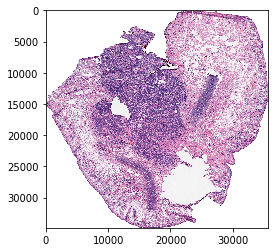

In [183]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
# build dzi

In [ ]:
# report generation

In [ ]:
# use dash to call prelim openseadragons; update with fine-tuned heatmaps

In [ ]:
# add more here; turn each cell into python script after testing
# arcticai package
# airflow scripts

In [ ]:
# OLD
# class Section:
#     def __init__(self, image='', depth=1, block_type=1):
        
    

# patient="163_A1"

# results=pd.read_pickle(f"results/{patient}.pkl")
# quality_score={k:dict(enumerate([pd.concat([pd.read_pickle(f)[k].iloc[:,section::results['n_blocks_per_section']].fillna(0) for f in results['quality_scores']],axis=1) for section in range(results['n_blocks_per_section'])])) for k in ['tumor','macro']}
# score per block per section ADD
# average across blocks?
def filter_mask(mask): # fill holes here (2 masks output) and ensure only have top X sections; find largest sections; do later
    macro_mask=fill_holes(mask)
    return mask, macro_mask

# holes for certain analysis type; rip from pathflow and lower dependencies
# preprocess
# analysis_type=""
# turn into custom dataset for pathpretrain eval
# predict(hidden_topology=[32]*3)
# predict_nuclei()